# PALLADIO example

## Imports

In [14]:
%matplotlib inline

import pandas as pd
import numpy as np

# Plotting
# import matplotlib
# matplotlib.use('Agg')

import palladio
import palladio.analysis
import palladio.plotting

from collections import namedtuple

# Dataset stuff
from palladio import datasets

# Classifiers
from sklearn.feature_selection import RFE
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline

# Model selection
from sklearn.model_selection import GridSearchCV


## Configuration

### Datasets

In [2]:
# Dataset loading
data_path = '/home/matteo/jdoe-shared/matteo/Thesis_experiments/Golub/data/gedm.csv'
target_path = '/home/matteo/jdoe-shared/matteo/Thesis_experiments/Golub/data/labels.csv'

data_loading_options = target_loading_options = {                                                                                                                                                                                  
    'delimiter': ',',                                                                                                                                                                                     
    'header': 0,                                                                                                                                                                                          
    'index_col': 0                                                                                                                                                                                        
}

dataset = datasets.load_csv(data_path, target_path,                                                                                                                                                       
                            data_loading_options=data_loading_options,                                                                                                                                    
                            target_loading_options=target_loading_options,                                                                                                                                
                            samples_on='col')                                                                                                                                                             
data, labels = dataset.data, dataset.target
feature_names = dataset.feature_names



### Session

In [3]:
# Subfolder where results will be saved
session_folder = '/tmp/results'

# The learning task, if None palladio tries to guess it
# [see sklearn.utils.multiclass.type_of_target]

learning_task = None

n_splits_permutation = 5
n_splits_regular = 5

### Learning algorithms

In [4]:
# STEP 1: Variable selection                                                                                                                                                                              
vs = RFE(LinearSVC(loss='hinge'), step=0.3)                                                                                                                                                               

# STEP 2: Classification                                                                                                                                                                                  
clf = LinearSVC(loss='hinge')                                                                                                                                                                             

# COMPOSE THE PIPELINE
pipe = Pipeline([
    ('variable_selection', vs),
    ('classification', clf),
])

# Set the estimator to be a GridSearchCV
param_grid = {
    'variable_selection__n_features_to_select': [10, 20, 50],
    'variable_selection__estimator__C': np.logspace(-4, 0, 5),
    'classification__C': np.logspace(-4, 0, 5),
}

estimator = GridSearchCV(pipe, param_grid=param_grid, cv=3, scoring='accuracy')

# Set options for ModelAssessment
ma_options = {
    'test_size': 0.25,
    'scoring': 'accuracy',
    'n_jobs': -1,
    'n_splits': n_splits_regular
}

### Analysis configuration

In [5]:
vs_analysis = 'variable_selection'

frequency_threshold = 0.75

# Plotting Options
score_surfaces_options = {
    'logspace': ['variable_selection__C'],
    'plot_errors': True
}

### Composing configuration object

In [6]:
# TODO must fix
class Struct:
    def __init__(self, **entries):
        self.__dict__.update(entries)
        
config_dict = {
    # Dataset
    'data' : data,
    'labels' : labels,
    'feature_names' : feature_names,
    # Session
    'session_folder' : session_folder,
    'learning_task' : learning_task,
    'n_splits_permutation' : n_splits_permutation,
    # Learning algorithm
    'estimator' : estimator,
    'param_grid' : param_grid,
    'ma_options' : ma_options,
    # Analysis
    'vs_analysis' : vs_analysis,
    'frequency_threshold' : frequency_threshold,
    'score_surfaces_options' : score_surfaces_options,
    
    
}

config = Struct(**config_dict)

## Experiment running

In [9]:
regular_batch, permutation_batch = palladio.job_distribution.main(config=config)

Loading dataset...
  * Data shape: (38, 7129)
  * Labels shape: (38,)


## Analysis

[accuracy_score] Two sample Kolmogorov-Smirnov test: Ks_2sampResult(statistic=1.0, pvalue=0.0037813540593701006)


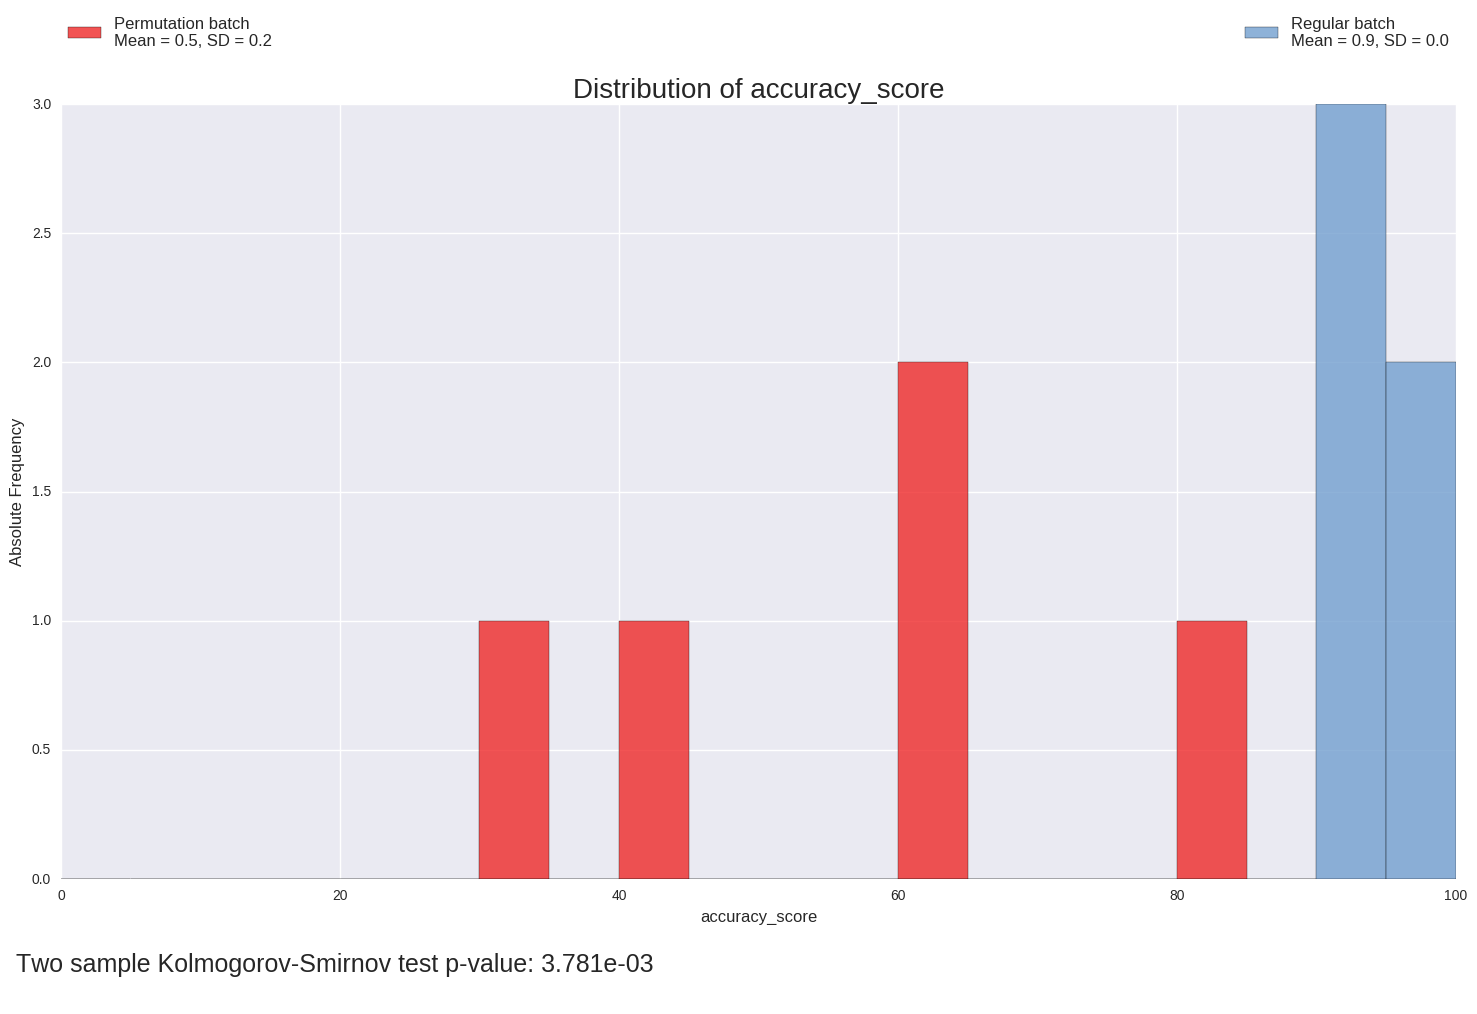

In [16]:
# palladio.analysis.analyse_results(base_folder="/tmp/results", analysis_folder='analysis', )

# palladio.analysis.analyse_results(regular_batch.cv_results_, 
#                                   permutation_batch.cv_results_,
#                                   config.labels,
#                                   config.estimator,
#                                   base_folder='/tmp/results',
#                                   feature_names=config.feature_names,
#                                   learning_task=None, vs_analysis='variable_selection',
#                                 threshold=.75, model_assessment_options=None,
#         analysis_folder='analysis',
#         score_surfaces_options={})

regular_batch.cv_results_

performance_regular = palladio.analysis.performance_metrics(
    regular_batch.cv_results_, 
    config.labels, 
    target='classification'
)

performance_permutation = palladio.analysis.performance_metrics(
    permutation_batch.cv_results_, 
    config.labels, 
    target='classification'
)

metric = 'accuracy_score'

palladio.plotting.distributions(
            v_regular=performance_regular[metric],
#             v_permutation=performance_permutation.get(metric, []),
            v_permutation=performance_permutation[metric],
            metric=metric
)

# performance_permutation
